# AI Second Project - Food_DataSet - Training_Models :)

## Episode1 - use Pre_Process Data And Make Data_Augmentation To Prevent Overfit In model

In [1]:
# import libraries we want
# pandas and numpy to work with dataFrame
import pandas as pd
import numpy as np
# tensorflow for make model
import tensorflow as tf
from tensorflow . keras . preprocessing.image import ImageDataGenerator
from tensorflow . keras . applications import MobileNetV2, ResNet50
from tensorflow . keras . layers import Dense, Dropout
from tensorflow . keras . models import Model
from sklearn . model_selection import train_test_split
# PIL library to use some process on image easy
from PIL import Image
import io
# use in the last part to have some correcting
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(image_bytes):
    # open the image from raw bytes
    image = Image . open(io.BytesIO(eval(image_bytes)))
    # resize images to all images have same size
    image = image . resize((224, 224))
    # convert pic into numpy array to work with it easier 
    image_array = np . array(image)
    return image_array

In [6]:
# create generators from a dataframe
def create_generators(df):
    # use previous function on main DataFrame
    df['Photo'] = df['Photo'] . apply(preprocess_image)
    # convert Label column from str into int to give this integers to model
    df['Label'] = pd . Categorical(df['Label'])
    df['Label'] = df['Label'] . cat . codes
    # split data into 2 part_ train and validation part 
    X_train, X_val, y_train, y_val = train_test_split(np . stack(df['Photo'] . values), df['Label'] . values, test_size = 0.2, random_state = 42)
    # make generators - we only use generator on train data and we don't change anything in validation data
    train_datagen = ImageDataGenerator(
    rescale = 1./255,  # Normalize pixel values to [0,1]
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )
    val_datagen = ImageDataGenerator(rescale = 1./255)
    # use above augmentation for data
    train_generator = train_datagen . flow(X_train, y_train, batch_size = 32)
    val_generator = val_datagen . flow(X_val, y_val, batch_size = 32)
    return train_generator, val_generator

In [44]:
# Make model - part1 - 3 dataset DataMaking
# load dataframes - part1 - pre_train_models
df1 = pd . read_csv('correct.csv')  # 100% correct data
df2 = pd . read_csv('wrong.csv')  # 100% wrong data
df3 = pd . read_csv('nothing.csv')  # nothing data (classes not in food101 dataset)
df4 = pd . read_csv('all_category_data.csv') # contain all classes
# we don't need 2 columns from data . Photo_Name and predict . so we delete them
df4 . drop(columns = 'Photo_Name' , inplace = True)
df1 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
df2 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
df3 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
# df4 is dataset that contain all classes data(22 row that each row is belong to one class)
# we concat this DataFrame to 3 DataFrame for making model don't give error
# each training part need have 22 classes but some of them have smaller classes ( for example df3 have 5 class)
df1 = pd . concat([df1 , df4])
df2 = pd . concat([df2 , df4])
df3 = pd . concat([df3 , df4])

In [ ]:
# load DataFrame - part2 - ALL_DATA_CONCAT data
df1 = pd . read_csv('correct.csv')
df2 = pd . read_csv('wrong.csv')
df3 = pd . read_csv('nothing.csv')
df1 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
df2 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
df3 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
df = pd . concat([df1 , df3])

In [5]:
# load DataFrame - part2 - ALL_DATA_CONCAT data except df2
# df2 is data that have many many wrong result in training model
# so in one model, we remove this data from our model
df1 = pd . read_csv('correct.csv')  # 100% correct
df3 = pd . read_csv('nothing.csv')  # nothing
df1 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
df3 . drop(columns = ['predict' , 'Photo_Name'] , inplace = True)
df = pd . concat([df1 , df3])

In [9]:
# generate data - part 1 - 3 data_separate_generating_data
train_gen1, val_gen1 = create_generators(df1)
train_gen2, val_gen2 = create_generators(df2)
train_gen3, val_gen3 = create_generators(df3)

In [7]:
# generate data - part2 - all data generate data
train_gen , val_gen = create_generators(df)

## Episode2 - Train The Correct.csv File 3 Times to Model Converge to Best Result

### Part1 Training - No Trainable Layer

In [36]:
# make the base model
# base model is MobileNetV2
# because of use high layer model, we only add a 1024 fully connected layer with activision Relu
def create_model():
    # add base model and it's weight that come from ImageNet
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'relu')(x)
    predictions = Dense(len(df1['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    # all layers must be UnTrainable and later we activate them
    for layer in base_model . layers:
        layer.trainable = False
    return model

In [32]:
# make model
model = create_model()
# give summary
model . summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [16]:
# Train model first time
model . fit(train_gen1, validation_data = val_gen1, epochs = 10)
# save the weights of model in .h5 file
model . save_weights('modelp1.h5')

Epoch 1/10
275/275 [==============================] - 160s 575ms/step - loss: 1.9203 - accuracy: 0.4883 - val_loss: 1.2487 - val_accuracy: 0.6431
Epoch 2/10
275/275 [==============================] - 152s 552ms/step - loss: 1.2931 - accuracy: 0.6266 - val_loss: 1.0791 - val_accuracy: 0.6746
Epoch 3/10
275/275 [==============================] - 150s 546ms/step - loss: 1.1489 - accuracy: 0.6640 - val_loss: 0.9983 - val_accuracy: 0.6959
Epoch 4/10
275/275 [==============================] - 156s 569ms/step - loss: 1.0547 - accuracy: 0.6896 - val_loss: 0.9718 - val_accuracy: 0.7096
Epoch 5/10
275/275 [==============================] - 162s 589ms/step - loss: 1.0019 - accuracy: 0.7053 - val_loss: 0.9177 - val_accuracy: 0.7164
Epoch 6/10
275/275 [==============================] - 159s 577ms/step - loss: 0.9525 - accuracy: 0.7194 - val_loss: 0.8800 - val_accuracy: 0.7251
Epoch 7/10
275/275 [==============================] - 165s 601ms/step - loss: 0.9078 - accuracy: 0.7262 - val_loss: 0.8511 -

### Part2 - 100 First Layer Is Non_Trainable

In [37]:
# make model
model = create_model()
# load model weights that we make in previous part
model . load_weights('modelp1.h5')
# all layers of base model is trainable
model . trainable = True
# but we freeze 100 first layer
for layer in model . layers[:100]:
    layer . trainable = False
model . summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [19]:
# compile model and training
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen1, validation_data = val_gen1, epochs = 10)
# save model
model . save_weights('modelp2.h5')

Epoch 1/10
275/275 [==============================] - 210s 744ms/step - loss: 1.1759 - accuracy: 0.6684 - val_loss: 0.8106 - val_accuracy: 0.7592
Epoch 2/10
275/275 [==============================] - 217s 789ms/step - loss: 0.8679 - accuracy: 0.7501 - val_loss: 0.7457 - val_accuracy: 0.7774
Epoch 3/10
275/275 [==============================] - 204s 742ms/step - loss: 0.7469 - accuracy: 0.7844 - val_loss: 0.6696 - val_accuracy: 0.8029
Epoch 4/10
275/275 [==============================] - 200s 727ms/step - loss: 0.6427 - accuracy: 0.8139 - val_loss: 0.5921 - val_accuracy: 0.8316
Epoch 5/10
275/275 [==============================] - 207s 752ms/step - loss: 0.5874 - accuracy: 0.8329 - val_loss: 0.5341 - val_accuracy: 0.8503
Epoch 6/10
275/275 [==============================] - 216s 784ms/step - loss: 0.5377 - accuracy: 0.8447 - val_loss: 0.4884 - val_accuracy: 0.8598
Epoch 7/10
275/275 [==============================] - 205s 746ms/step - loss: 0.4877 - accuracy: 0.8582 - val_loss: 0.4617 -

### Part 3 - All Layers Are Trainable

In [38]:
# make model
model = create_model()
model . load_weights('modelp2.h5')
model . trainable = True
for layer in model . layers:
    layer . trainable = True
model . summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [45]:
# compile model
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen1, validation_data = val_gen1, epochs = 10)
# save model
model . save_weights('modelp3.h5')

Epoch 1/10
275/275 [==============================] - 586s 2s/step - loss: 0.4319 - accuracy: 0.8726 - val_loss: 0.3761 - val_accuracy: 0.8912
Epoch 2/10
275/275 [==============================] - 592s 2s/step - loss: 0.3772 - accuracy: 0.8904 - val_loss: 0.3710 - val_accuracy: 0.8990
Epoch 3/10
275/275 [==============================] - 579s 2s/step - loss: 0.3463 - accuracy: 0.8979 - val_loss: 0.3664 - val_accuracy: 0.8976
Epoch 4/10
275/275 [==============================] - 561s 2s/step - loss: 0.3216 - accuracy: 0.9052 - val_loss: 0.3418 - val_accuracy: 0.9021
Epoch 5/10
275/275 [==============================] - 560s 2s/step - loss: 0.2892 - accuracy: 0.9157 - val_loss: 0.3228 - val_accuracy: 0.9108
Epoch 6/10
275/275 [==============================] - 576s 2s/step - loss: 0.2736 - accuracy: 0.9187 - val_loss: 0.3154 - val_accuracy: 0.9203
Epoch 7/10
275/275 [==============================] - 598s 2s/step - loss: 0.2464 - accuracy: 0.9273 - val_loss: 0.3146 - val_accuracy: 0.9208

### Part4 - Use Dropout on First Model Training To Achieve Better Result

In [45]:
# all parts are same as before and we also add dropout with value of 0.5
def create_model():
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(df1['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    for layer in base_model . layers:
        layer . trainable = False
    return model

In [ ]:
# make model
model = create_model()
model . load_weights('modelp3.h5')
model . trainable = True
for layer in model . layers:
    layer . trainable = True

In [47]:
# compile model and training
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen1, validation_data = val_gen1, epochs = 3)
# save model
model . save_weights('modelp3.h5')

Epoch 1/3
275/275 [==============================] - 621s 2s/step - loss: 0.2013 - accuracy: 0.9396 - val_loss: 0.3008 - val_accuracy: 0.9162
Epoch 2/3
275/275 [==============================] - 580s 2s/step - loss: 0.1910 - accuracy: 0.9455 - val_loss: 0.3005 - val_accuracy: 0.9199
Epoch 3/3
275/275 [==============================] - 603s 2s/step - loss: 0.1712 - accuracy: 0.9505 - val_loss: 0.2969 - val_accuracy: 0.9226


## Episode3 - Train The Wrong.csv File 3 Times to Model Converge to Best Result

### Part1 Training - No Trainable Layer

In [51]:
# make model by function write below
# because of complexity and high wrong label value count, we use Dropout in all parts
def create_model():
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(df1['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    for layer in base_model . layers:
        layer . trainable = False
    return model

In [ ]:
# make model - in first part we don't need add any trainable layer
model = create_model()
model . load_weights('modelp3.h5')

In [52]:
# train model
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen2, validation_data = val_gen2, epochs = 15)
# save model
model . save_weights('modelp4.h5')

Epoch 1/15
171/171 [==============================] - 98s 548ms/step - loss: 1.3015 - accuracy: 0.6830 - val_loss: 1.2384 - val_accuracy: 0.6923
Epoch 2/15
171/171 [==============================] - 93s 544ms/step - loss: 1.2792 - accuracy: 0.6790 - val_loss: 1.2188 - val_accuracy: 0.6938
Epoch 3/15
171/171 [==============================] - 94s 550ms/step - loss: 1.2580 - accuracy: 0.6931 - val_loss: 1.2019 - val_accuracy: 0.6952
Epoch 4/15
171/171 [==============================] - 94s 550ms/step - loss: 1.2572 - accuracy: 0.6871 - val_loss: 1.1878 - val_accuracy: 0.6974
Epoch 5/15
171/171 [==============================] - 93s 545ms/step - loss: 1.2065 - accuracy: 0.6931 - val_loss: 1.1758 - val_accuracy: 0.6982
Epoch 6/15
171/171 [==============================] - 98s 573ms/step - loss: 1.2429 - accuracy: 0.6905 - val_loss: 1.1647 - val_accuracy: 0.7004
Epoch 7/15
171/171 [==============================] - 95s 552ms/step - loss: 1.2166 - accuracy: 0.6944 - val_loss: 1.1549 - val_ac

### Part2 - 100 First Layer Is Non_Trainable

In [ ]:
# trainable item
model = create_model()
model . load_weights('modelp4.h5')
model . trainable = True
for layer in model.layers[:100]:
    layer . trainable = False

In [54]:
# compile model and train it
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen2, validation_data = val_gen2, epochs = 15)
# save model
model . save_weights('modelp4.h5')

Epoch 1/15
171/171 [==============================] - 132s 744ms/step - loss: 1.1691 - accuracy: 0.6920 - val_loss: 0.9823 - val_accuracy: 0.7385
Epoch 2/15
171/171 [==============================] - 127s 740ms/step - loss: 0.9995 - accuracy: 0.7169 - val_loss: 0.9435 - val_accuracy: 0.7414
Epoch 3/15
171/171 [==============================] - 127s 740ms/step - loss: 0.9061 - accuracy: 0.7358 - val_loss: 0.9096 - val_accuracy: 0.7538
Epoch 4/15
171/171 [==============================] - 127s 742ms/step - loss: 0.8562 - accuracy: 0.7428 - val_loss: 0.8885 - val_accuracy: 0.7597
Epoch 5/15
171/171 [==============================] - 128s 750ms/step - loss: 0.8018 - accuracy: 0.7585 - val_loss: 0.8653 - val_accuracy: 0.7656
Epoch 6/15
171/171 [==============================] - 126s 737ms/step - loss: 0.7440 - accuracy: 0.7737 - val_loss: 0.8433 - val_accuracy: 0.7656
Epoch 7/15
171/171 [==============================] - 127s 740ms/step - loss: 0.7250 - accuracy: 0.7779 - val_loss: 0.8327 -

### Part 3 - All Layers Are Trainable

In [ ]:
# make model
model = create_model()
model . load_weights('modelp4.h5')
model . trainable = True
for layer in model . layers:
    layer . trainable = True

In [55]:
# compile model and train it
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen2, validation_data = val_gen2, epochs = 10)
# save model
model . save_weights('modelp5.h5')

Epoch 1/10
171/171 [==============================] - 412s 2s/step - loss: 0.5298 - accuracy: 0.8388 - val_loss: 0.7415 - val_accuracy: 0.7927
Epoch 2/10
171/171 [==============================] - 395s 2s/step - loss: 0.4830 - accuracy: 0.8488 - val_loss: 0.7424 - val_accuracy: 0.7919
Epoch 3/10
171/171 [==============================] - 395s 2s/step - loss: 0.4617 - accuracy: 0.8573 - val_loss: 0.7540 - val_accuracy: 0.7934
Epoch 4/10
171/171 [==============================] - 398s 2s/step - loss: 0.4525 - accuracy: 0.8593 - val_loss: 0.7497 - val_accuracy: 0.7949
Epoch 5/10
171/171 [==============================] - 403s 2s/step - loss: 0.4550 - accuracy: 0.8609 - val_loss: 0.7475 - val_accuracy: 0.7978
Epoch 6/10
171/171 [==============================] - 398s 2s/step - loss: 0.4229 - accuracy: 0.8664 - val_loss: 0.7395 - val_accuracy: 0.7956
Epoch 7/10
171/171 [==============================] - 395s 2s/step - loss: 0.4045 - accuracy: 0.8738 - val_loss: 0.7519 - val_accuracy: 0.7956

## Episode4 - Train The Nothing.csv File 3 Times to Model Converge to Best Result

### Part1 Training - No Trainable Layer

In [56]:
def create_model():
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(df1['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    for layer in base_model . layers:
        layer . trainable = False
    return model

In [ ]:
# make model and load weights
model = create_model()
model.load_weights('modelp5.h5')

In [58]:
model . compile(optimizer = tf . keras.optimizers . Adam(1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen3, validation_data = val_gen3, epochs = 15)
model . save_weights('modelp6.h5')

Epoch 1/15
158/158 [==============================] - 100s 621ms/step - loss: 2.8371 - accuracy: 0.3332 - val_loss: 1.1465 - val_accuracy: 0.5767
Epoch 2/15
158/158 [==============================] - 92s 584ms/step - loss: 1.0050 - accuracy: 0.6597 - val_loss: 0.8214 - val_accuracy: 0.7310
Epoch 3/15
158/158 [==============================] - 93s 587ms/step - loss: 0.7902 - accuracy: 0.7349 - val_loss: 0.6865 - val_accuracy: 0.7729
Epoch 4/15
158/158 [==============================] - 92s 582ms/step - loss: 0.6928 - accuracy: 0.7695 - val_loss: 0.6123 - val_accuracy: 0.7872
Epoch 5/15
158/158 [==============================] - 91s 576ms/step - loss: 0.6364 - accuracy: 0.7818 - val_loss: 0.5806 - val_accuracy: 0.8030
Epoch 6/15
158/158 [==============================] - 92s 580ms/step - loss: 0.6013 - accuracy: 0.7942 - val_loss: 0.5545 - val_accuracy: 0.8022
Epoch 7/15
158/158 [==============================] - 93s 585ms/step - loss: 0.5625 - accuracy: 0.8091 - val_loss: 0.5408 - val_a

### Part2 - 100 First Layer Is Non_Trainable

In [ ]:
# make model and freeze first 100 layer
model = create_model()
model . load_weights('modelp6.h5')
model . trainable = True
for layer in model . layers[:100]:
    layer . trainable = False

In [63]:
# compile model and train
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen3, validation_data = val_gen3, epochs = 10)
# save model
model . save_weights('modelp7.h5')

Epoch 1/10
158/158 [==============================] - 151s 925ms/step - loss: 0.5217 - accuracy: 0.8178 - val_loss: 0.5091 - val_accuracy: 0.8220
Epoch 2/10
158/158 [==============================] - 127s 806ms/step - loss: 0.4481 - accuracy: 0.8461 - val_loss: 0.4801 - val_accuracy: 0.8402
Epoch 3/10
158/158 [==============================] - 128s 812ms/step - loss: 0.4036 - accuracy: 0.8680 - val_loss: 0.4601 - val_accuracy: 0.8426
Epoch 4/10
158/158 [==============================] - 128s 812ms/step - loss: 0.3769 - accuracy: 0.8740 - val_loss: 0.4260 - val_accuracy: 0.8560
Epoch 5/10
158/158 [==============================] - 127s 805ms/step - loss: 0.3500 - accuracy: 0.8805 - val_loss: 0.3978 - val_accuracy: 0.8631
Epoch 6/10
158/158 [==============================] - 127s 803ms/step - loss: 0.3153 - accuracy: 0.8945 - val_loss: 0.3747 - val_accuracy: 0.8616
Epoch 7/10
158/158 [==============================] - 127s 800ms/step - loss: 0.2988 - accuracy: 0.9009 - val_loss: 0.3622 -

## Episode5 - Train Model On ConCat ALL 3 DataFrames 

### Part1 - 100 FIrst Layer is Non_Trainable

In [22]:
def create_model():
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(df['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    for layer in base_model . layers:
        layer . trainable = False
    return model

In [ ]:
# make model and freeze 100 first layer
model = create_model()
model.load_weights('modelpfinal.h5')
model.trainable = True
for layer in model . layers[:100]:
    layer . trainable = False

In [19]:
# compile model and train
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen, validation_data = val_gen, epochs = 10)
# save model
model . save_weights('modelpfinal.h5')

Epoch 1/10
602/602 [==============================] - 469s 771ms/step - loss: 0.4576 - accuracy: 0.8568 - val_loss: 0.4661 - val_accuracy: 0.8603
Epoch 2/10
602/602 [==============================] - 459s 762ms/step - loss: 0.4103 - accuracy: 0.8723 - val_loss: 0.4396 - val_accuracy: 0.8695
Epoch 3/10
602/602 [==============================] - 513s 852ms/step - loss: 0.3931 - accuracy: 0.8763 - val_loss: 0.4311 - val_accuracy: 0.8720
Epoch 4/10
602/602 [==============================] - 472s 784ms/step - loss: 0.3710 - accuracy: 0.8804 - val_loss: 0.4250 - val_accuracy: 0.8759
Epoch 5/10
602/602 [==============================] - 473s 786ms/step - loss: 0.3483 - accuracy: 0.8897 - val_loss: 0.4110 - val_accuracy: 0.8799
Epoch 6/10
602/602 [==============================] - 449s 745ms/step - loss: 0.3419 - accuracy: 0.8943 - val_loss: 0.4091 - val_accuracy: 0.8820
Epoch 7/10
602/602 [==============================] - 462s 768ms/step - loss: 0.3229 - accuracy: 0.8962 - val_loss: 0.4018 -

### Part2 - All Layers Are Non_Trainable And Dropout is 0.2 lower

In [11]:
def create_model():
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'tanh')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(df['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    for layer in base_model . layers:
        layer . trainable = False
    return model

In [ ]:
# make model and load weights
model = create_model()
model . load_weights('modelpfinal.h5')

In [12]:
# compile and train model
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen, validation_data = val_gen, epochs = 10)
# save weights
model . save_weights('modelpfinal2.h5')

Epoch 1/10
602/602 [==============================] - 353s 583ms/step - loss: 0.3025 - accuracy: 0.9217 - val_loss: 0.6614 - val_accuracy: 0.8647
Epoch 2/10
602/602 [==============================] - 354s 588ms/step - loss: 0.2969 - accuracy: 0.9240 - val_loss: 0.6448 - val_accuracy: 0.8678
Epoch 3/10
602/602 [==============================] - 352s 585ms/step - loss: 0.2875 - accuracy: 0.9246 - val_loss: 0.6335 - val_accuracy: 0.8707
Epoch 4/10
602/602 [==============================] - 370s 615ms/step - loss: 0.2700 - accuracy: 0.9283 - val_loss: 0.6254 - val_accuracy: 0.8726
Epoch 5/10
602/602 [==============================] - 367s 610ms/step - loss: 0.2686 - accuracy: 0.9286 - val_loss: 0.6182 - val_accuracy: 0.8730
Epoch 6/10
602/602 [==============================] - 366s 608ms/step - loss: 0.2753 - accuracy: 0.9277 - val_loss: 0.6127 - val_accuracy: 0.8743
Epoch 7/10
602/602 [==============================] - 387s 643ms/step - loss: 0.2707 - accuracy: 0.9301 - val_loss: 0.6084 -

### Part3 - All Layers Are Trainable And Dropout Is 0.1 Lower

In [32]:
def create_model():
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(len(df['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    return model

In [ ]:
# make model and load weights
model = create_model()
model.load_weights('modelpfinal2.h5')

In [34]:
# compile and train model
model . compile(optimizer = tf . keras.optimizers . Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen, validation_data = val_gen, epochs = 5)
# save model
model . save_weights('modelpfinal3.h5')

Epoch 1/5
602/602 [==============================] - 1336s 2s/step - loss: 0.2799 - accuracy: 0.9123 - val_loss: 0.4099 - val_accuracy: 0.8865
Epoch 2/5
602/602 [==============================] - 1307s 2s/step - loss: 0.2743 - accuracy: 0.9142 - val_loss: 0.4015 - val_accuracy: 0.8847
Epoch 3/5
602/602 [==============================] - 1228s 2s/step - loss: 0.2503 - accuracy: 0.9201 - val_loss: 0.4006 - val_accuracy: 0.8857
Epoch 4/5
602/602 [==============================] - 1262s 2s/step - loss: 0.2473 - accuracy: 0.9217 - val_loss: 0.4022 - val_accuracy: 0.8855
Epoch 5/5
602/602 [==============================] - 1306s 2s/step - loss: 0.2420 - accuracy: 0.9244 - val_loss: 0.4013 - val_accuracy: 0.8886


## Episode6 - Add Warm_Up Learning_rate To Adam Optimizer

### Part0 - Define Warm_up Class

In [8]:
# import callbacks from tensorflow library to add warm_up learning rate
from tensorflow.keras.callbacks import Callback
# Define the warmup learning rate scheduler
class warm_up(tf.keras.callbacks.Callback):
    # initial value of class using init function
    def __init__(self, ws, il, tl): # ws = warmup_steps / il = initial_lr / tl = target_lr
        super(warm_up, self) . __init__()
        self . ws = ws
        self . il = il
        self . tl = tl
    # find learning_rate that we give to adam in each epoch
    def on_epoch_begin(self, epoch, logs = None):
        if epoch < self . ws:
            lr = self . il + (self . tl - self . il) * (epoch / self . ws)
        else:
            lr = self . target_lr
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        print(f"\nEpoch {epoch+1}: Learning rate is {lr:.6f}")

### Part1 - Some Checks And HyperParameter Finding

In [10]:
def create_model():
    base_model = MobileNetV2(weights = 'imagenet', input_shape = (224, 224, 3))
    x = base_model . output
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(df['Label'] . unique()), activation = 'softmax')(x)
    model = Model(inputs = base_model . input, outputs = predictions)
    for layer in base_model . layers:
        layer.trainable = False
    return model

In [ ]:
# create model and load weights
model = create_model()
model . load_weights('modelpfinal5.h5')
model . trainable = True
for layer in model . layers[:100]:
    layer . trainable = False

In [21]:
# initialize values of warmup_learning_rate
warmup_steps = 2
initial_lr = 1e-7
target_lr = 1e-5
# compile model
model . compile(optimizer = tf.keras.optimizers.Adam(initial_lr), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# create warmup learning_rate method and train model ( here we have little epochs because fine_tune parameters of warmup and check result )
warmup_scheduler = warm_up(warmup_steps, initial_lr, target_lr)
model . fit(train_gen, validation_data = val_gen, epochs = 3, callbacks = [warmup_scheduler])
# save model
model . save_weights('modelpfinal5.h5')


Epoch 1: Learning rate is 0.000000
Epoch 1/3
602/602 [==============================] - 477s 783ms/step - loss: 0.0984 - accuracy: 0.9717 - val_loss: 0.3984 - val_accuracy: 0.8975

Epoch 2: Learning rate is 0.000005
Epoch 2/3
602/602 [==============================] - 479s 796ms/step - loss: 0.0974 - accuracy: 0.9710 - val_loss: 0.3988 - val_accuracy: 0.8980

Epoch 3: Learning rate is 0.000010
Epoch 3/3
602/602 [==============================] - 485s 805ms/step - loss: 0.0971 - accuracy: 0.9698 - val_loss: 0.4042 - val_accuracy: 0.8946


### Part2 - Train The Best Model of Data Here using Warm_up

In [ ]:
# make model and freeze first 100 layer
model = create_model()
model . load_weights('modelpfinal5.h5')
model . trainable = True
for layer in model . layers[:100]:
    layer . trainable = False

In [50]:
# initialize values of warmup_learning_rate
warmup_steps = 10
initial_lr = 1e-5
target_lr = 1e-9
# compile model
model . compile(optimizer = tf.keras.optimizers.Adam(initial_lr), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Create the warmup learning rate scheduler
warmup_scheduler = warm_up(warmup_steps, initial_lr, target_lr)
# create warmup learning_rate method and train model
model . fit(train_gen, validation_data = val_gen, epochs = 15, callbacks = [warmup_scheduler])
# save model
model . save_weights('modelpfinalfinal.h5')


Epoch 1: Learning rate is 0.000010
Epoch 1/15
602/602 [==============================] - 477s 783ms/step - loss: 0.3779 - accuracy: 0.8860 - val_loss: 0.3997 - val_accuracy: 0.8930

Epoch 2: Learning rate is 0.000009
Epoch 2/15
602/602 [==============================] - 478s 793ms/step - loss: 0.3448 - accuracy: 0.8949 - val_loss: 0.4032 - val_accuracy: 0.8932

Epoch 3: Learning rate is 0.000008
Epoch 3/15
602/602 [==============================] - 489s 812ms/step - loss: 0.3420 - accuracy: 0.8974 - val_loss: 0.4116 - val_accuracy: 0.8917

Epoch 4: Learning rate is 0.000007
Epoch 4/15
602/602 [==============================] - 487s 808ms/step - loss: 0.3325 - accuracy: 0.8968 - val_loss: 0.4148 - val_accuracy: 0.8913

Epoch 5: Learning rate is 0.000006
Epoch 5/15
602/602 [==============================] - 484s 804ms/step - loss: 0.3331 - accuracy: 0.8966 - val_loss: 0.4100 - val_accuracy: 0.8905

Epoch 6: Learning rate is 0.000005
Epoch 6/15
602/602 [==============================] - 

## Ova Episode - Delete Wrong Data Part

In [ ]:
# make model and freeze first 100 layer
model = create_model()
model . load_weights('modelpfinalfinal.h5')
model . trainable = True
for layer in model . layers[:100]:
    layer . trainable = False

In [11]:
# initialize values of warmup_learning_rate
warmup_steps = 10
initial_lr = 1e-5
target_lr = 1e-8
# compile model
model . compile(optimizer = tf.keras.optimizers.Adam(initial_lr), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Create the warmup learning rate scheduler
warmup_scheduler = warm_up(warmup_steps, initial_lr, target_lr)
# create warmup learning_rate method and train model
model . fit(train_gen, validation_data = val_gen, epochs = 15, callbacks = [warmup_scheduler])
# save model
model . save_weights('modelpfinalfinal.h5')


Epoch 1: Learning rate is 0.000010
Epoch 1/10
432/432 [==============================] - 462s 1s/step - loss: 0.1518 - accuracy: 0.9549 - val_loss: 0.1280 - val_accuracy: 0.9629

Epoch 2: Learning rate is 0.000008
Epoch 2/10
432/432 [==============================] - 440s 1s/step - loss: 0.1334 - accuracy: 0.9605 - val_loss: 0.1236 - val_accuracy: 0.9647

Epoch 3: Learning rate is 0.000006
Epoch 3/10
432/432 [==============================] - 368s 852ms/step - loss: 0.1244 - accuracy: 0.9637 - val_loss: 0.1281 - val_accuracy: 0.9647

Epoch 4: Learning rate is 0.000004
Epoch 4/10
432/432 [==============================] - 362s 839ms/step - loss: 0.1222 - accuracy: 0.9627 - val_loss: 0.1286 - val_accuracy: 0.9667

Epoch 5: Learning rate is 0.000002
Epoch 5/10
432/432 [==============================] - 367s 849ms/step - loss: 0.1159 - accuracy: 0.9656 - val_loss: 0.1270 - val_accuracy: 0.9661

Epoch 6: Learning rate is 0.000000
Epoch 6/10
432/432 [==============================] - 366s 8

## Commercial Break

### Part1 - Correcting_Data_Part

In [26]:
# we have 3 class of labels . first one is for correcting model / second is for df3 / third one is class of final model we make
class_labels1 = ['baklava', 'caesar_salad', 'cheesecake', 'chicken_curry', 'chocolate_cake', 'donuts', 'eggs', 'falafel', 
                        'fish', 'french_fries', 'hamburger', 'hot_dog', 'ice_cream', 'lasagna', 'omelette', 'pizza', 
                        'spaghetti' , 'steak' , 'sushi']
class_labels2 = ['cheese_sandwich', 'chicken' , 'chicken_curry' , 'falafel' , 'ice_cream' , 'steak']
class_labels3 = ['baked_potato','baklava', 'caesar_salad','cheese_sandwich', 'cheesecake','chicken', 'chicken_curry', 'chocolate_cake', 'donuts', 'eggs', 'falafel', 
                        'fish', 'french_fries', 'hamburger', 'hot_dog', 'ice_cream', 'lasagna', 'omelette', 'pizza', 
                        'spaghetti' , 'steak' , 'sushi']
# use this function to convert prediction from int into str by above lists
def class_labels(pclp1 , flag):
    if flag == 1:
        pclp2 = class_labels1[pclp1]
    elif flag == 2:
        pclp2 = class_labels3[pclp1]
    else:
        pclp2 = class_labels2[pclp1]
    return pclp2

In [16]:
# load DataFrame of Correct data
df12 = pd . read_csv('correct.csv')  # 100% correct
df12 . drop(columns = ['predict'] , inplace = True)
df12['Photo'] = df12['Photo'] . apply(preprocess_image)
df12['Label'] = pd . Categorical(df12['Label'])
df12['Label'] = df12['Label'] . cat . codes

In [ ]:
# load DataFrame of wrong data
df12 = pd . read_csv('wrong.csv')  # 100% wrong
df12 . drop(columns = ['predict'] , inplace = True)
df12['Photo'] = df12['Photo'] . apply(preprocess_image)
df12['Label'] = pd . Categorical(df12['Label'])
df12['Label'] = df12['Label'] . cat . codes

In [17]:
# we need to divide value of pixels of given image to 255
# also our picture have 3 channel color . so we expand dim of it
# in the end, we predict value
def pred1(img):
    img = img / 255
    if img.shape[-1] != 3:
        img = img[..., :3]
    # add a batch dimension
    img = np . expand_dims(img, axis = 0)
    # Predict using the model
    pred = model . predict(img , verbose = 0)
    return pred

In [34]:
from PIL import Image
import numpy as np
# make specific DataFrame
dff1 = df12[df12['Label'] == 0]
# Train check - first part _ predict
predict_list1 = []
for item in dff1['Photo']:
    pred_item = pred1(item)
    predict_list1 . append(pred_item)
# get the item with higher accuracy in each prediction
predict_list2 = []
for item in predict_list1:
    pci = np . argmax(item) # predict_class_index
    predict_list2 . append(pci)
dff1['predict'] = predict_list2
dff2 = dff1[dff1['Label'] != dff1['predict']]

C:\Users\amir\AppData\Local\Temp\ipykernel_20016\2810077249.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff1['predict'] = predict_list2


In [35]:
predicted_list3 = [] # predict photo
predicted_list4 = [] # name of photo
for i , j , k in zip(dff2['predict'] , dff2['Label'] , dff2['Photo_Name']):
    predicted_list3 . append(class_labels(i,2))
    predicted_list4 . append(k)

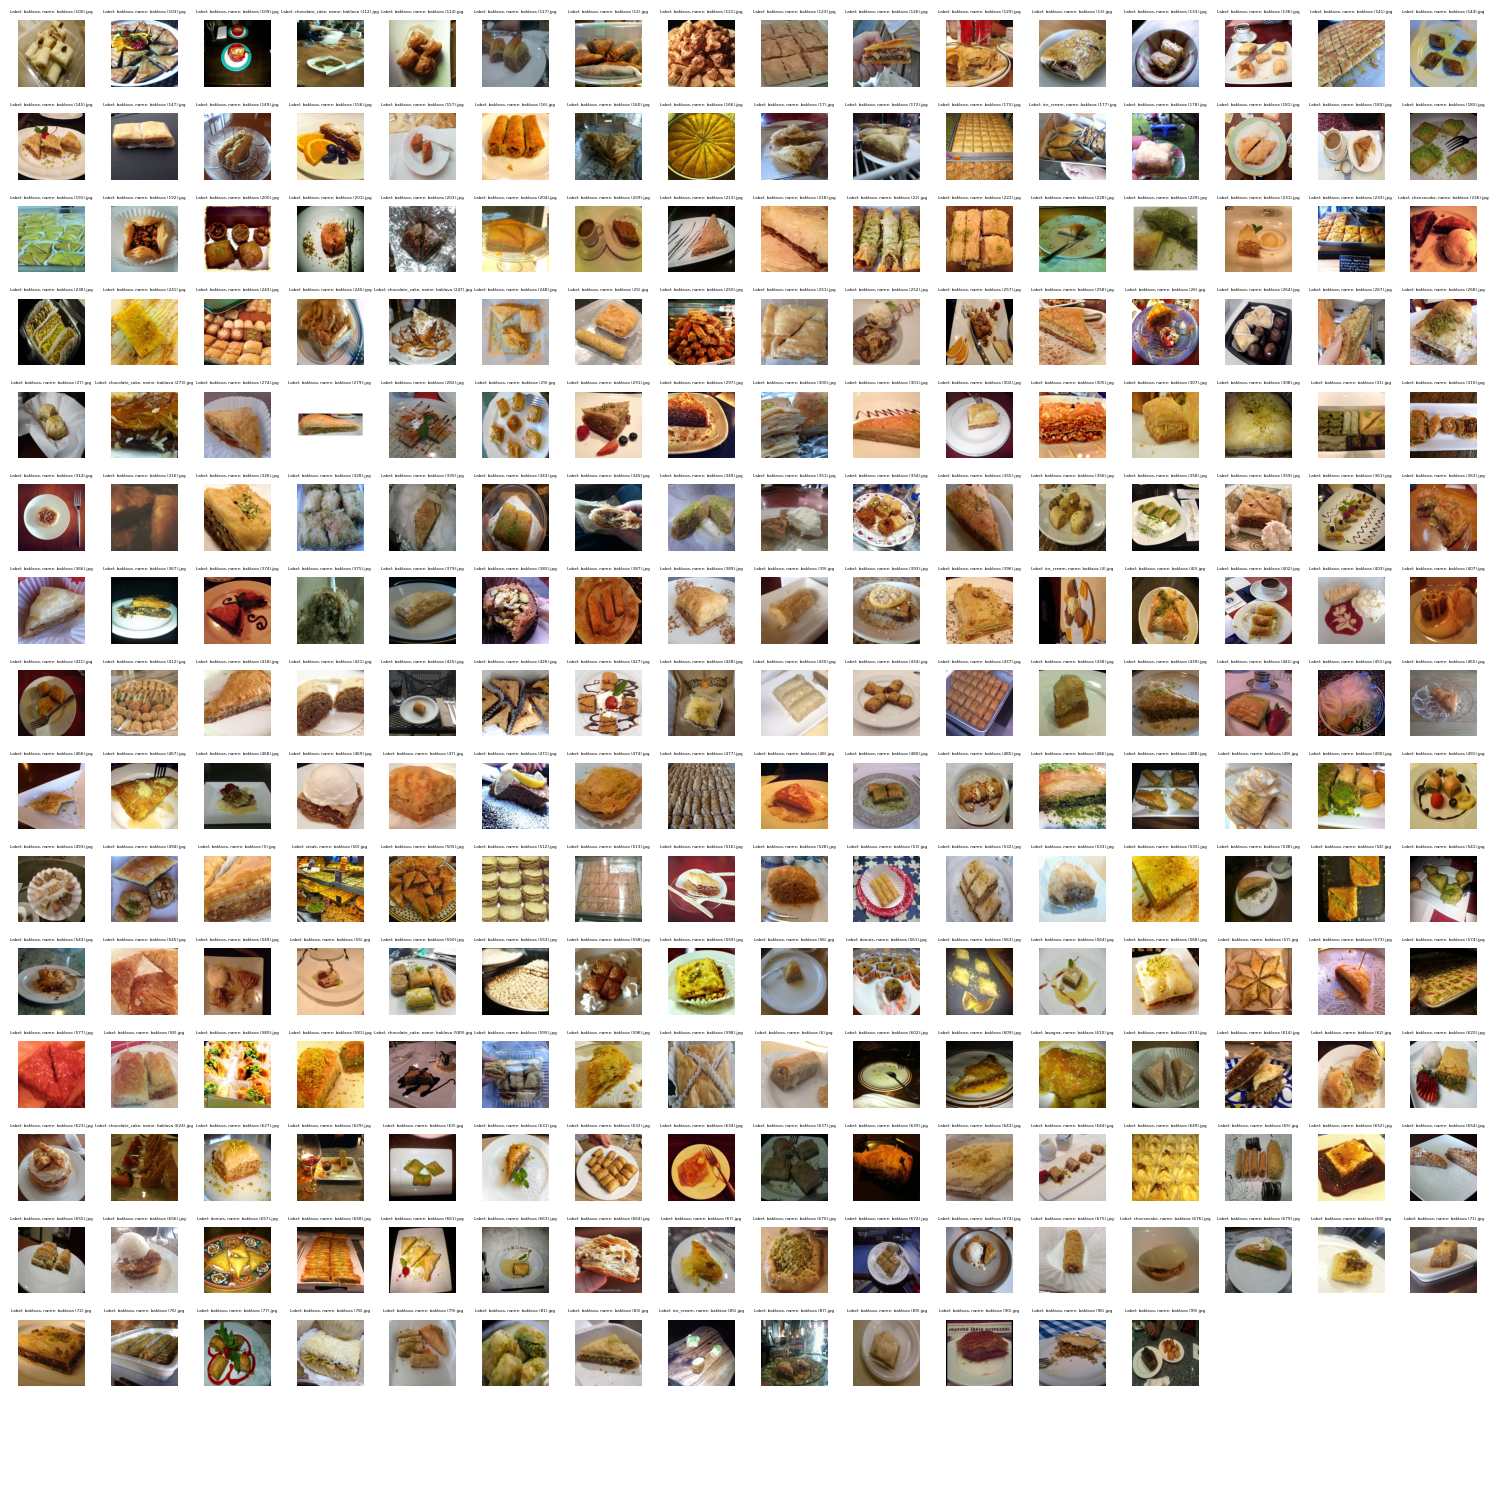

In [36]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# give the images
dfff2 = dff2 . reset_index()
images = dfff2['Photo']
# grid the images
ni = len(images) # number of images
gs = math . ceil(math . sqrt(ni))
# make a plot
fig, axes = plt . subplots(gs, gs, figsize = (15, 15))
axes = axes . flatten()
# plot_images
for i, img in enumerate(images):
    axes[i] . imshow(img)
    axes[i] . axis('off')
    axes[i] . set_title(f'Label: {predicted_list3[i]}, name: {predicted_list4[i]}', fontsize=3)  # Add the index and label as title
# hide unused_subplots
for i in range(ni, len(axes)):
    axes[i] . axis('off')
# show the plot
plt . tight_layout()
plt . show()

### Part2 - Wrong Data And Some Information About Data

In [235]:
names = {'baklava (108).jpg' : 'lasagna' , 'caesar_salad (469).jpg' : 'fish' , 'cheesecake (87).jpg':'chocolate_cake' , 'cheesecake (638).jpg' : 'chocolate_cake',
        'chicken_curry (223).jpg' : 'omelette' ,'chicken_curry (545).jpg' : 'steak', 'chocolate_cake (136).jpg' : 'falafel','donuts (1079).jpg' : 'ice_cream' ,'donuts (272).jpg' : 'ice_cream' , 'eggs (337).jpg' : 'lasagna',
        'fish (129).jpg' : 'omelette' , 'fish (344).jpg' : 'french_fries' , 'lasagna (584).jpg' : 'pizza' , 'omelette (172).jpg' : 'pizza' , 'omelette (251).jpg' : 'eggs' , 'omelette (252).jpg' : 'eggs' ,
        'omelette (372).jpg' : 'omelette' , 'omelette (511).jpg' : 'eggs' , 'pizza (404).jpg' : 'lasagna' , 'steak (404).jpg' : 'french_fries'}

In [ ]:
# check model on classes
# omelette = 48
# cheesecake = 42
# baklava = 30
# hamburger = 30
# hot_dog = 29
# chicken_curry = 26
# falafel = 26
# eggs = 23
# lasagna = 22
# spaghetti = 20
# chocolate_cake = 19
# donuts = 19
# fish = 13
# ice_cream = 15
# steak = 15
# french_fries = 13
# pizza = 10
# caesar_salad = 4

In [241]:
# correct df1 DataFrame and fix photo that have wrong label
df1 = pd . read_csv('correct.csv')
df1['Label'] = df1['Photo_Name'] . map(names) . fillna(df1['Label'])
df1 = df1[~df1['Photo_Name'] . isin(delete_names)]
df1 . to_csv('modified_dataset.csv', index=False)

## Last Episode - Check Model On Images From Internet

In [23]:
# all classes data labels
class_labels = ['baked_potato','baklava', 'caesar_salad','cheese_sandwich', 'cheesecake','chicken', 'chicken_curry', 'chocolate_cake', 'donuts', 'eggs', 'falafel', 
                        'fish', 'french_fries', 'hamburger', 'hot_dog', 'ice_cream', 'lasagna', 'omelette', 'pizza', 
                        'spaghetti' , 'steak' , 'sushi']
def class_labels1(pclp):
    pclpf = class_labels[pclp]
    return pclpf

In [21]:
def pred1(img):
    img = img / 255
    if img.shape[-1] != 3:
        img = img[..., :3]
    # add a batch dimension
    img = np . expand_dims(img, axis = 0)
    # Predict using the model
    pred = new_model . predict(img , verbose = 0)
    return pred

In [ ]:
# make model
new_model = create_model()
# load weights
#new_model . load_weights('modelpfinalfinal2.h5')

In [30]:
immmg1 = Image.open('pic1.jpg')
immmg1 = immmg1.resize((224, 224))
immmg1 = np.array(immmg1)
img1 = np . argmax(pred1(immmg1))
print(f'class: {class_labels1(img1)}')

class: cheesecake
